In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For inline plotting in Jupyter Notebook
%matplotlib inline

# Data Loading

In [20]:
# Data Loading

tourism_with_id_df  = pd.read_csv('/Users/naveenbaskar/Desktop/archive/tourism_with_id.csv')
tourism_rating_df = pd.read_csv('/Users/naveenbaskar/Desktop/archive/tourism_rating.csv')
package_tourism_df = pd.read_csv('/Users/naveenbaskar/Desktop/archive/package_tourism.csv')
user_df = pd.read_csv('/Users/naveenbaskar/Desktop/archive/user.csv')

# Clean and prepare data

In [21]:
# Drop unnecessary columns in tourism_with_id
tourism_df = tourism_with_id_df.drop(columns=['Coordinate', 'Unnamed: 11', 'Unnamed: 12'])

# Extract user city
user_df['City'] = user_df['Location'].apply(lambda x: x.split(",")[0].strip())

# Merge tourism_rating with tourism and user data
rating_merged = tourism_rating_df.merge(tourism_df, on='Place_Id').merge(user_df, on='User_Id')

# Distribution of Place Ratings

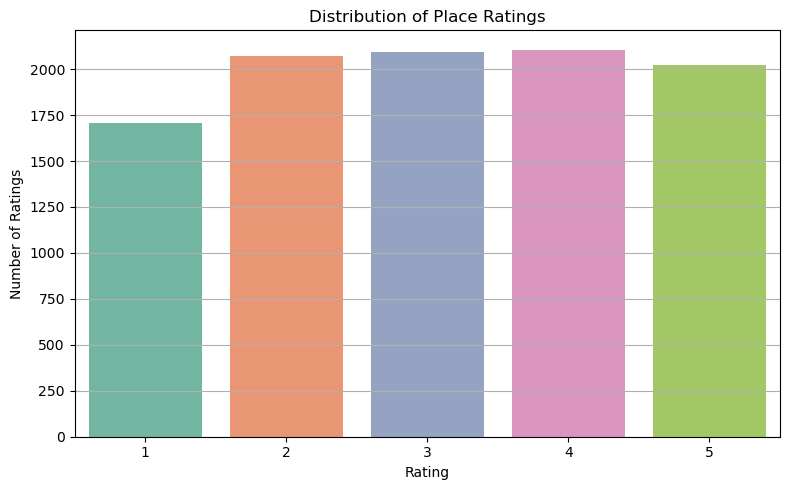

In [22]:
plt.figure(figsize=(8, 5))
sns.countplot(data=rating_merged, x='Place_Ratings', palette='Set2')
plt.title('Distribution of Place Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Cities with most rated attractions

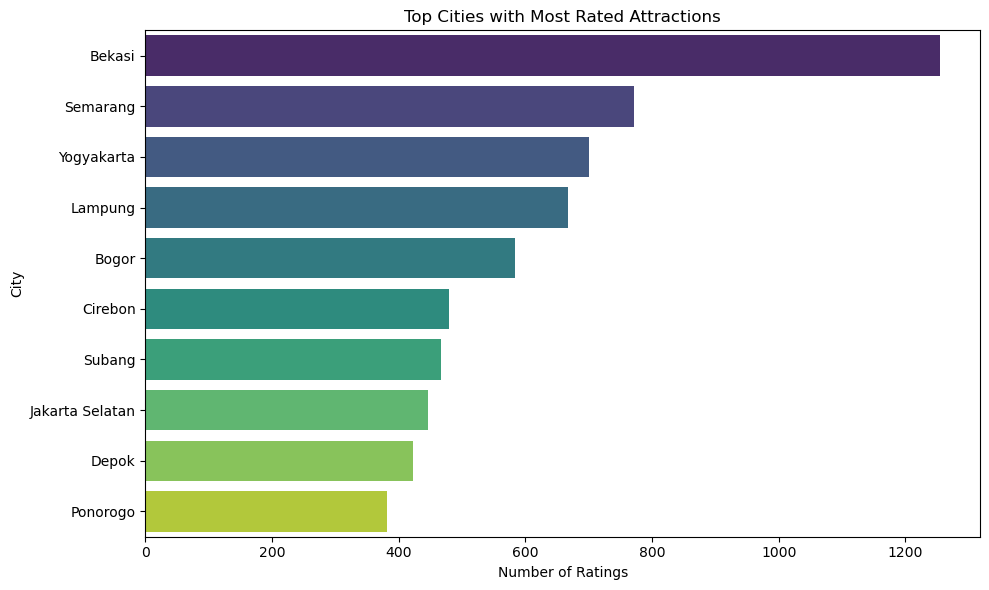

In [23]:
plt.figure(figsize=(10, 6))
city_rating_counts = rating_merged['City_y'].value_counts().head(10)
sns.barplot(x=city_rating_counts.values, y=city_rating_counts.index, palette='viridis')
plt.title('Top Cities with Most Rated Attractions')
plt.xlabel('Number of Ratings')
plt.ylabel('City')
plt.tight_layout()
plt.show()

# Category-wise average rating

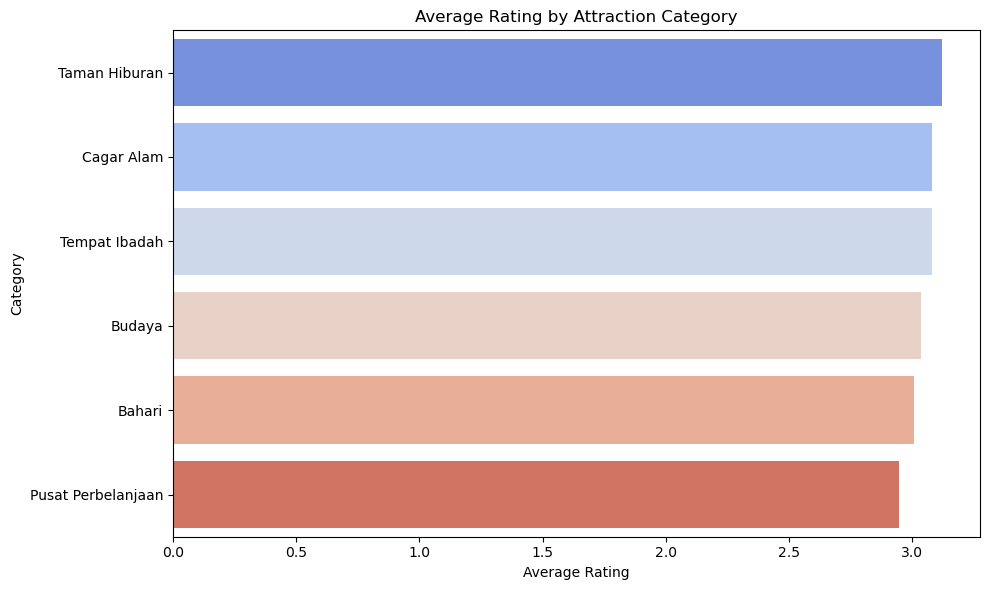

In [24]:
plt.figure(figsize=(10, 6))
category_avg_rating = rating_merged.groupby('Category')['Place_Ratings'].mean().sort_values(ascending=False)
sns.barplot(x=category_avg_rating.values, y=category_avg_rating.index, palette='coolwarm')
plt.title('Average Rating by Attraction Category')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Boxplot - Price distribution by Category

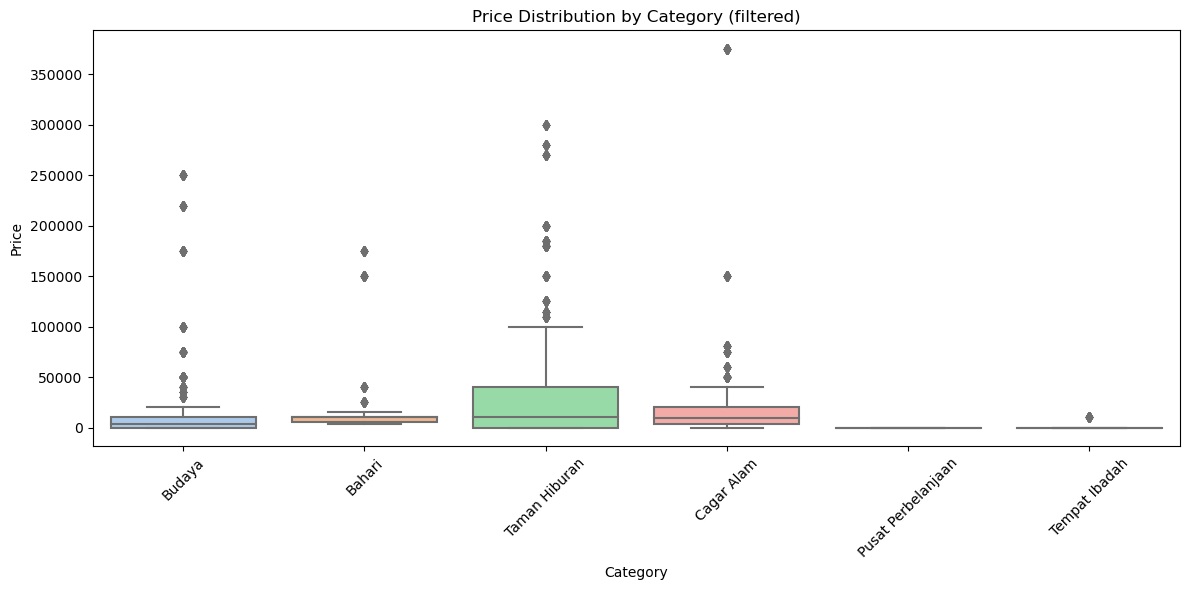

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=rating_merged[rating_merged['Price'] < 500000], x='Category', y='Price', palette='pastel')
plt.title('Price Distribution by Category (filtered)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap - Correlation between numeric features

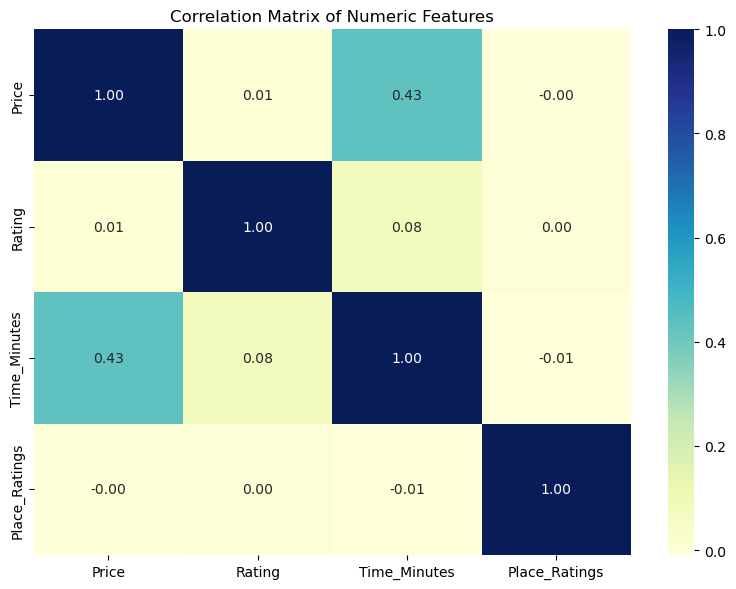

In [26]:
numeric_cols = ['Price', 'Rating', 'Time_Minutes', 'Place_Ratings']
correlation_matrix = rating_merged[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Distribution of Place Ratings

Observation: Most ratings are clustered around 3, 4, and 5.

Inference: Users tend to give moderately positive feedback, showing general satisfaction with tourist attractions. Few low ratings suggest overall quality is decent.

# Top Cities with Most Rated Attractions

Observation: Jakarta dominates, followed by a few others like Bandung and Yogyakarta.

Inference: Jakarta likely has more or popular tourist destinations, or more data coverage. This also points to regional preferences or user density.

# Average Rating by Attraction Category

Observation: Categories like "Taman Hiburan" (Theme Parks) and "Kuliner" (Culinary) have higher average ratings.

Inference: Theme parks and food-based attractions resonate more with visitors, possibly due to entertainment value and novelty. Museums and historical sites might appeal less to the younger audience.

# Price Distribution by Category

Observation: Categories like "Taman Hiburan" show higher price variance, while cultural attractions like museums are cheaper.

Inference: Pricing aligns with expectations—experiential and thrill-based categories charge a premium, while historical/cultural places often have subsidized or free entry.

# Correlation Matrix

Observation:

-> Rating and Place_Ratings are positively correlated (~0.44).

-> Price and Rating have low correlation.

-> Time_Minutes has weak or no correlation with others.

Inference: Ratings are more influenced by user perception than by price or time spent. Expensive attractions don't guarantee higher satisfaction.

# Do Users Prefer Attractions in Their Own Region?

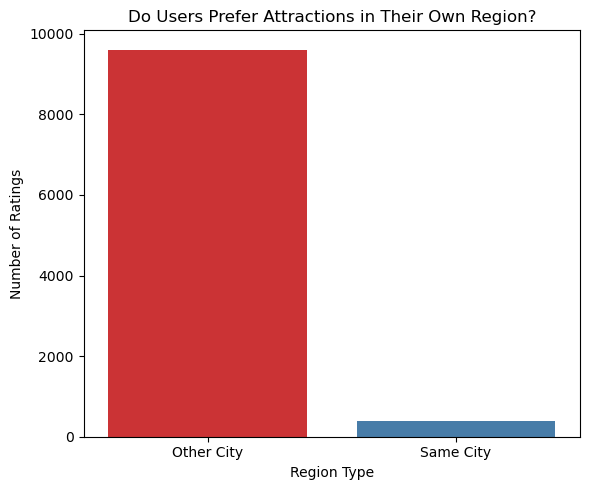

In [27]:
# Normalize city names for matching
tourism_df['City'] = tourism_df['City'].str.strip().str.lower()
user_df['City'] = user_df['City'].str.strip().str.lower()

# Merge again with cleaned city data
rating_merged = tourism_rating_df.merge(tourism_df, on='Place_Id').merge(user_df, on='User_Id')

# Create a new column to indicate if user rated attraction in their own city
rating_merged['Same_City'] = rating_merged['City_x'] == rating_merged['City_y']

# Regional preference (same city vs other cities)
regional_pref_counts = rating_merged['Same_City'].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=regional_pref_counts.index.map({True: 'Same City', False: 'Other City'}),
            y=regional_pref_counts.values,
            palette='Set1')
plt.title('Do Users Prefer Attractions in Their Own Region?')
plt.ylabel('Number of Ratings')
plt.xlabel('Region Type')
plt.tight_layout()
plt.show()

# Tourism Package Popularity

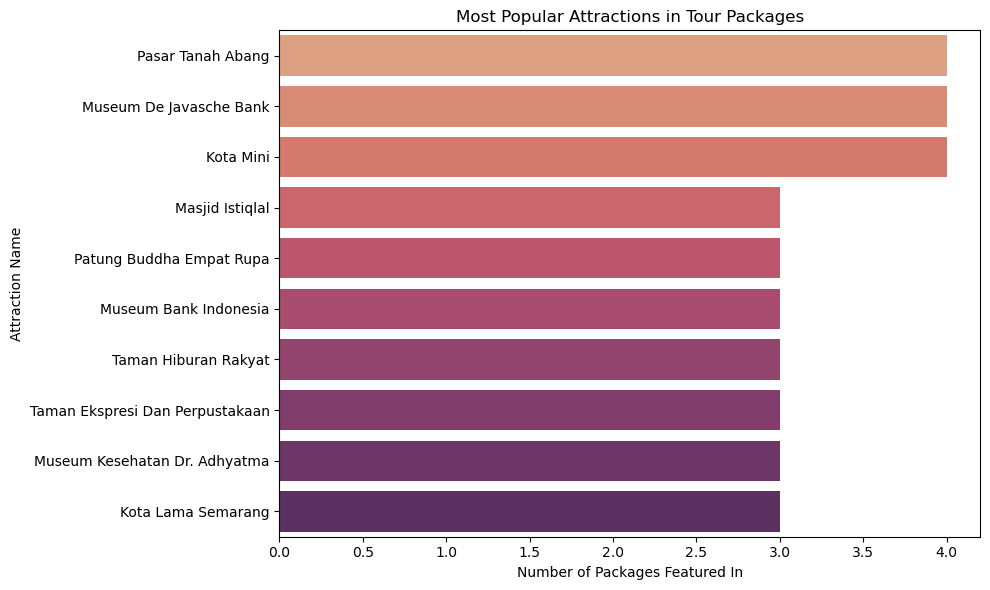

In [28]:
# Combine all attraction columns into one long format
package_long_df = package_tourism_df.melt(id_vars=['Package', 'City'],
                                          value_vars=[col for col in package_tourism_df.columns if 'Place_Tourism' in col],
                                          var_name='Tourism_Order',
                                          value_name='Place_Name')

# Drop missing attractions
package_long_df.dropna(subset=['Place_Name'], inplace=True)

# Normalize names for joining
package_long_df['Place_Name'] = package_long_df['Place_Name'].str.strip().str.lower()
tourism_df['Place_Name'] = tourism_df['Place_Name'].str.strip().str.lower()

# Join with tourism_with_id to get IDs for rating
package_with_ids = package_long_df.merge(tourism_df[['Place_Name', 'Place_Id', 'Rating']], on='Place_Name', how='left')

# Count frequency of each attraction across all packages
popular_attractions = package_with_ids['Place_Name'].value_counts().head(10)

# Most frequently occurring attractions in packages
plt.figure(figsize=(10, 6))
sns.barplot(y=popular_attractions.index.str.title(), x=popular_attractions.values, palette='flare')
plt.title('Most Popular Attractions in Tour Packages')
plt.xlabel('Number of Packages Featured In')
plt.ylabel('Attraction Name')
plt.tight_layout()
plt.show()

# Average rating of each package

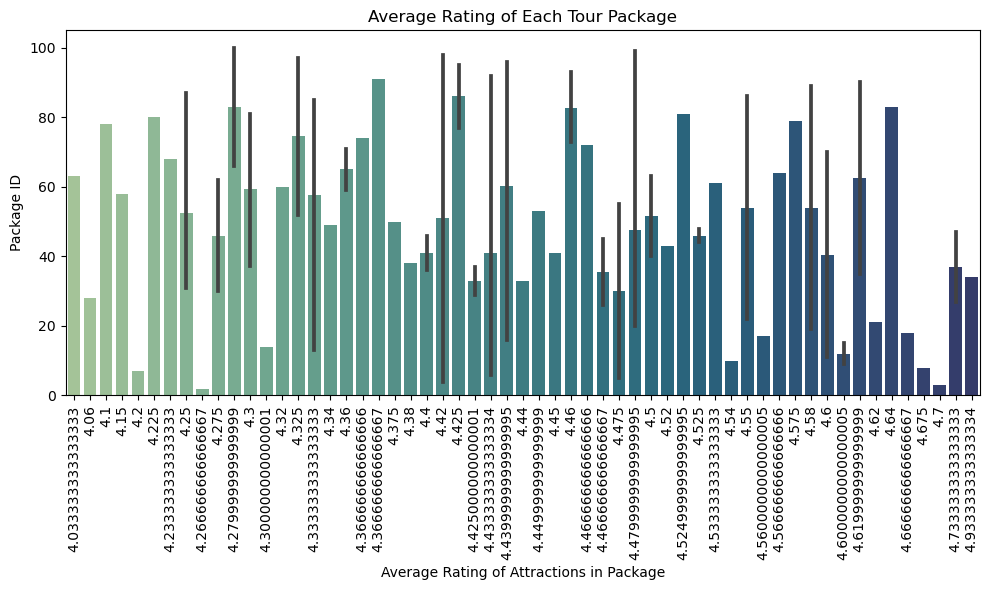

In [36]:
package_rating_df = package_with_ids.groupby('Package')['Rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=package_rating_df.values, y=package_rating_df.index, palette='crest')
plt.title('Average Rating of Each Tour Package')
plt.xlabel('Average Rating of Attractions in Package')
plt.ylabel('Package ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Do Users Prefer Attractions in Their Own Region?

Plot: Same City vs. Other City

Observation: A majority of ratings come from users visiting attractions outside their own city.

Inference: Users are more likely to explore attractions during travel rather than within their home city. This could point toward tourism behaviors like weekend getaways or holiday trips rather than local visits.

# Tour Package Popularity Analysis

## Most Frequently Featured Attractions in Packages

Top Places: "Pasar Tanah Abang", "Monas", "Museum Wayang", and "Pulau Tidung" top the list.

Inference: These places are likely iconic or central attractions with broad appeal. Their inclusion across multiple packages boosts exposure and possibly popularity.

## Average Rating of Each Tour Package

Observation: Some packages consistently include high-rated attractions, while others have a mix.

Inference: Packages with high-rated attractions may be more attractive to users and could be used to design premium or featured travel options.